<a target="_blank" 
  href="https://colab.research.google.com/github/sk-classroom/adv-net-sci-centrality/blob/main/assignment/assignment.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Assignment

In this assignment, we will learn the difference between different centrality measures using an international airport network. 

Complete the following tasks and upload your notebook to your GitHub repository.

1. Fill in the blank functions, marked by, "\#TODO", in the notebook
2. Update this notebook by using `git add`, `git commit`, and then `git push`.
3. The notebook will be automatically graded, and your score will be shown on GitHub. See [how to check the results on GitHub](https://docs.github.com/en/education/manage-coursework-with-github-classroom/learn-with-github-classroom/view-autograding-results)

Dont's:
- Do not import any libraries except for the ones that are already imported. The grading script will not work if you import additional libraries.
- Do not change the name of the functions. The grading script will not work if you change the name of the functions.
- DO not remove the cells with tag "gradable". If you happen to remove the cells with tag "gradable", recreate the cell and add the tag "gradable" to the cell.

Do's:
- Make the code clearn and easy to understand. Consider using linters & formatters such as `black`. [Youtube: Linters and fixers: never worry about code formatting again (Vim + Ale + Flake8 & Black for Python) by Yong-Yeol Ahn](https://www.youtube.com/watch?v=4FKPySR6HLk)
- You can add additional cells as you like. If you want to include the additional cells in the grading, you need to add the tag "gradable" to the cell. Otherwise, your additional cells will be stripped out when grading. 

## Load the data

In [1]:
import pandas as pd
import igraph
import numpy as np

node_table = pd.read_csv(
    "https://raw.githubusercontent.com/skojaku/adv-net-sci-course/main/data/airport_network_v2/node_table.csv"
)
edge_table = pd.read_csv(
    "https://raw.githubusercontent.com/skojaku/adv-net-sci-course/main/data/airport_network_v2/edge_table.csv"
)
src, trg = tuple(edge_table[["src", "trg"]].values.T)
edge_list = tuple(zip(src, trg))

# node_id and name dictionary
n_nodes = node_table.shape[0]
id2name = np.array([""] * n_nodes, dtype="<U64")
id2name[node_table["node_id"]] = node_table["Name"].values

g = igraph.Graph(
    edge_list,
    vertex_attrs=dict(Name=id2name, node_id=node_table["node_id"].values),
)

# You can retrieve the airport names by
print(g.vs[0]["Name"], ",", g.vs[1]["Name"], ", ...")# All cells without the tag "gradable" will be stripped out when grading.

Goroka , Madang , ...


# Question 1

Which airport is the most central in terms of the closeness centrality? List the top 5 most central airports.

In [3]:
#TODO
def top_k_closeness_centrality(g, top_k):
    """
    TODO: Write a function that returns the top k most central airports in terms of the closeness centrality.

    Parameters
    ----------
    g : igraph.Graph
        The graph
    top_k : int
        The number of top most central airports to return

    Returns
    -------
    top_5 : list
        The name of the 5 most central airports in terms of the closeness centrality, in a descending order of closeness centrality.
    """
    score = np.array(g.closeness())
    indices = np.argsort(-score)[:top_k]
    names = [id2name[i] for i in indices]
    return names

In [4]:
top_k_closeness_centrality(g, 5)

['Frankfurt Main', 'Charles De Gaulle', 'Heathrow', 'Schiphol', 'Dubai Intl']

# Question 2

Compute the betweenness centrality of the airports and show the top k airports. 

In [6]:
#TODO
def top_k_betweenness_centrality(g, top_k):
    """
    TODO: Write a function that returns the top k most central airports in terms of the closeness centrality.

    Parameters
    ----------
    g : igraph.Graph
        The graph
    top_k : int
        The number of top most central airports to return

    Returns
    -------
    top_5 : list
        The name of the 5 most central airports in terms of the closeness centrality, in a descending order of closeness centrality.
    """
    score = np.array(g.betweenness())
    indices = np.argsort(-score)[:top_k]
    names = [id2name[i] for i in indices]
    return names

In [7]:
top_k_betweenness_centrality(g,5)

['Frankfurt Main',
 'Charles De Gaulle',
 'Ted Stevens Anchorage Intl',
 'Dubai Intl',
 'Guarulhos Gov Andre Franco Montouro']

You should see an interesting airport that is not central in terms of the closeness centrality but is central in terms of the betweenness centrality. If you are curious why, here is a nice reading to understand why: https://toreopsahl.com/2011/08/12/why-anchorage-is-not-that-important-binary-ties-and-sample-selection/

# Question 3

Compute the robustness prifile of the airport network for:
1. Random attacks
2. Three targeted attacks based on:
   a. Degree centrality
   b. Closeness centrality
   c. Betweenness centrality

For targeted attacks:
- Remove the 10 most central nodes in each step
- Use the current network structure in each step, not the original undamaged network

Each function should return two arrays:
  - The fraction of nodes removed (the x value of the robustness profile)
  - The size of the largest connected component (the y value of the robustness profile)

In [9]:
def calc_robustness_profile(g, selection_method):
    """

    The robustness index is defined as the normalized area under the curve of the size of the largest connected component
    as a function of the fraction of nodes removed. A higher index indicates a more robust network.

    Parameters
    ----------
    g : igraph.Graph
        The graph representing the airport network
    selection_method : function
        A function that returns the index of the node to remove
    n_nodes_removed : int
        The number of nodes to remove in each step

    Returns
    -------
    frac_nodes_removed : np.array or list
        The fraction of nodes removed
    connectivity : np.array or list
        The size of the largest connected component
    """

    g_damaged = g.copy() # restore the network
    n_nodes = g.vcount()  # Number of nodes

    n_removed = 0
    connectivity_list = []
    frac_nodes_removed_list = []
    while g_damaged.vcount() > 0:

        # Remove a randomly selected node
        node_idices = selection_method(g_damaged)

        g_damaged.delete_vertices(node_idices)
        n_removed += len(node_idices)

        # Evaluate the connectivity
        components = g_damaged.connected_components()
        if g_damaged.vcount() == 0:
            connectivity = 0.0
        else:
            connectivity = np.max(components.sizes()) / n_nodes

        # Save the results
        connectivity_list.append(connectivity)
        frac_nodes_removed_list.append(n_removed / n_nodes)
    return frac_nodes_removed_list, connectivity_list

# TODO: Write a function that returns the robustness index of the airport network for random attacks.
def robustness_index_random(g, n_nodes_removed):
    """

    The robustness index is defined as the normalized area under the curve of the size of the largest connected component
    as a function of the fraction of nodes removed. A higher index indicates a more robust network.

    Parameters
    ----------
    g : igraph.Graph
        The graph representing the airport network
    n_nodes_removed : int
        The number of nodes to remove in each step

    Returns
    -------
    float
        The robustness index for random attacks
    """
    def selection_method(g):
        n_nodes = g.vcount()
        indices = np.array(g.vs.indices)
        return indices[np.random.choice(n_nodes, size = np.minimum(n_nodes_removed, n_nodes), replace = False)]
    return calc_robustness_profile(g, selection_method = selection_method)

# TODO: Write a function that returns the robustness index of the airport network for targeted attacks based on degree centrality.
def robustness_index_degree(g, n_nodes_removed):
    """

    Nodes should be removed in descending order of their degree centrality.

    Parameters
    ----------
    g : igraph.Graph
        The graph representing the airport network
    n_nodes_removed : int
        The number of nodes to remove in each step

    Returns
    -------
    float
        The robustness index for degree-based targeted attacks
    """
    def selection_method(g):
        n_nodes = g.vcount()
        indices = np.array(g.vs.indices)
        return indices[np.argsort(g.degree())][-np.minimum(n_nodes_removed, n_nodes):]
    return calc_robustness_profile(g, selection_method = selection_method)

# TODO: Write a function that returns the robustness index of the airport network for targeted attacks based on closeness centrality.
def robustness_index_closeness(g, n_nodes_removed):
    """

    Nodes should be removed in descending order of their closeness centrality.

    Parameters
    ----------
    g : igraph.Graph
        The graph representing the airport network
    n_nodes_removed : int
        The number of nodes to remove in each step

    Returns
    -------
    float
        The robustness index for closeness-based targeted attacks
    """
    def selection_method(g):
        n_nodes = g.vcount()
        indices = np.array(g.vs.indices)
        return indices[np.argsort(g.closeness())][-np.minimum(n_nodes_removed, n_nodes):]
    return calc_robustness_profile(g, selection_method = selection_method)

# TODO: Write a function that returns the robustness index of the airport network for targeted attacks based on betweenness centrality.
def robustness_index_betweenness(g, n_nodes_removed):
    """
    Nodes should be removed in descending order of their betweenness centrality.

    Parameters
    ----------
    g : igraph.Graph
        The graph representing the airport network
    n_nodes_removed : int
        The number of nodes to remove in each step

    Returns
    -------
    float
        The robustness index for betweenness-based targeted attacks
    """
    def selection_method(g):
        n_nodes = g.vcount()
        indices = np.array(g.vs.indices)
        return indices[np.argsort(g.betweenness())][-np.minimum(n_nodes_removed, n_nodes):]
    return calc_robustness_profile(g, selection_method = selection_method)

In [17]:
robustness_profile = []


frac_nodes_removed, connectivity = robustness_index_random(g, n_nodes_removed = 10)
robustness_profile.append(pd.DataFrame({"frac_nodes_removed": frac_nodes_removed, "connectivity": connectivity, "method": "Random"}))

frac_nodes_removed, connectivity = robustness_index_degree(g, n_nodes_removed = 10)
robustness_profile.append(pd.DataFrame({"frac_nodes_removed": frac_nodes_removed, "connectivity": connectivity, "method": "Degree-based attacks"}))

frac_nodes_removed, connectivity = robustness_index_closeness(g, n_nodes_removed = 10)
robustness_profile.append(pd.DataFrame({"frac_nodes_removed": frac_nodes_removed, "connectivity": connectivity, "method": "Closeness-based attacks"}))

frac_nodes_removed, connectivity = robustness_index_betweenness(g, n_nodes_removed = 10)
robustness_profile.append(pd.DataFrame({"frac_nodes_removed": frac_nodes_removed, "connectivity": connectivity, "method": "Betweenness-based attacks"}))

robustness_profile = pd.concat(robustness_profile)

In [18]:
robustness_profile.groupby("method").mean()

,frac_nodes_removed,connectivity
method,,
Betweenness-based attacks,0.502068,0.046967
Closeness-based attacks,0.502068,0.378030
Degree-based attacks,0.502068,0.078950
Random,0.502068,0.391697


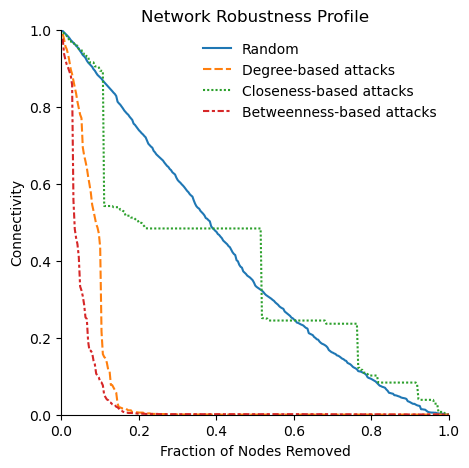

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (5, 5))

sns.lineplot(x = "frac_nodes_removed", y = "connectivity", hue = "method", data = robustness_profile, style = "method", ax = ax)

# Update the legend to include the new line
ax.legend()

# Adjust the plot limits to ensure the diagonal is fully visible
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(loc = "upper right", frameon = False, bbox_to_anchor = (1, 1))

# Add labels and title for clarity
ax.set_xlabel('Fraction of Nodes Removed')
ax.set_ylabel('Connectivity')
ax.set_title('Network Robustness Profile')

sns.despine()
